In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
df = pd.read_csv("Microsoft_Stock.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


## Data Exploration and Cleaning

### Dtypes check

In [3]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [4]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

### Describe fn

In [5]:
desc = df.describe()
print(desc,"\n")
info = df.info()


                                Date         Open         High          Low  \
count                           1511  1511.000000  1511.000000  1511.000000   
mean   2018-03-31 17:23:44.751820032   107.385976   108.437472   106.294533   
min              2015-04-01 16:00:00    40.340000    40.740000    39.720000   
25%              2016-09-29 04:00:00    57.860000    58.060000    57.420000   
50%              2018-04-02 16:00:00    93.990000    95.100000    92.920000   
75%              2019-10-01 04:00:00   139.440000   140.325000   137.825000   
max              2021-03-31 16:00:00   245.030000   246.130000   242.920000   
std                              NaN    56.691333    57.382276    55.977155   

             Close        Volume  
count  1511.000000  1.511000e+03  
mean    107.422091  3.019863e+07  
min      40.290000  1.016120e+05  
25%      57.855000  2.136213e+07  
50%      93.860000  2.662962e+07  
75%     138.965000  3.431962e+07  
max     244.990000  1.352271e+08  
std     

### Missing days check

In [6]:
dr = pd.date_range(
    start = "2015-04-01 16:00:00",
    end = "2021-03-31 16:00:00",
    freq = "D"
)
dr

DatetimeIndex(['2015-04-01 16:00:00', '2015-04-02 16:00:00',
               '2015-04-03 16:00:00', '2015-04-04 16:00:00',
               '2015-04-05 16:00:00', '2015-04-06 16:00:00',
               '2015-04-07 16:00:00', '2015-04-08 16:00:00',
               '2015-04-09 16:00:00', '2015-04-10 16:00:00',
               ...
               '2021-03-22 16:00:00', '2021-03-23 16:00:00',
               '2021-03-24 16:00:00', '2021-03-25 16:00:00',
               '2021-03-26 16:00:00', '2021-03-27 16:00:00',
               '2021-03-28 16:00:00', '2021-03-29 16:00:00',
               '2021-03-30 16:00:00', '2021-03-31 16:00:00'],
              dtype='datetime64[ns]', length=2192, freq='D')

In [7]:
missing = dr.difference(df.Date)
print(missing)

DatetimeIndex(['2015-04-03 16:00:00', '2015-04-04 16:00:00',
               '2015-04-05 16:00:00', '2015-04-11 16:00:00',
               '2015-04-12 16:00:00', '2015-04-18 16:00:00',
               '2015-04-19 16:00:00', '2015-04-25 16:00:00',
               '2015-04-26 16:00:00', '2015-05-02 16:00:00',
               ...
               '2021-02-27 16:00:00', '2021-02-28 16:00:00',
               '2021-03-06 16:00:00', '2021-03-07 16:00:00',
               '2021-03-13 16:00:00', '2021-03-14 16:00:00',
               '2021-03-20 16:00:00', '2021-03-21 16:00:00',
               '2021-03-27 16:00:00', '2021-03-28 16:00:00'],
              dtype='datetime64[ns]', length=690, freq=None)


### Missing values and dupe check

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df = df.set_index("Date")
df

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455


In [10]:
print("Per-row missing values:\n",df.isna().sum(axis = 1)) # Date NaN values
print(f"Percentage of total missing values: {(df.isna().sum().sum() / df.size) * 100}%") # Percentage of total NaN values

Per-row missing values:
 Date
2015-04-01 16:00:00    0
2015-04-02 16:00:00    0
2015-04-06 16:00:00    0
2015-04-07 16:00:00    0
2015-04-08 16:00:00    0
                      ..
2021-03-25 16:00:00    0
2021-03-26 16:00:00    0
2021-03-29 16:00:00    0
2021-03-30 16:00:00    0
2021-03-31 16:00:00    0
Length: 1511, dtype: int64
Percentage of total missing values: 0.0%


## First view

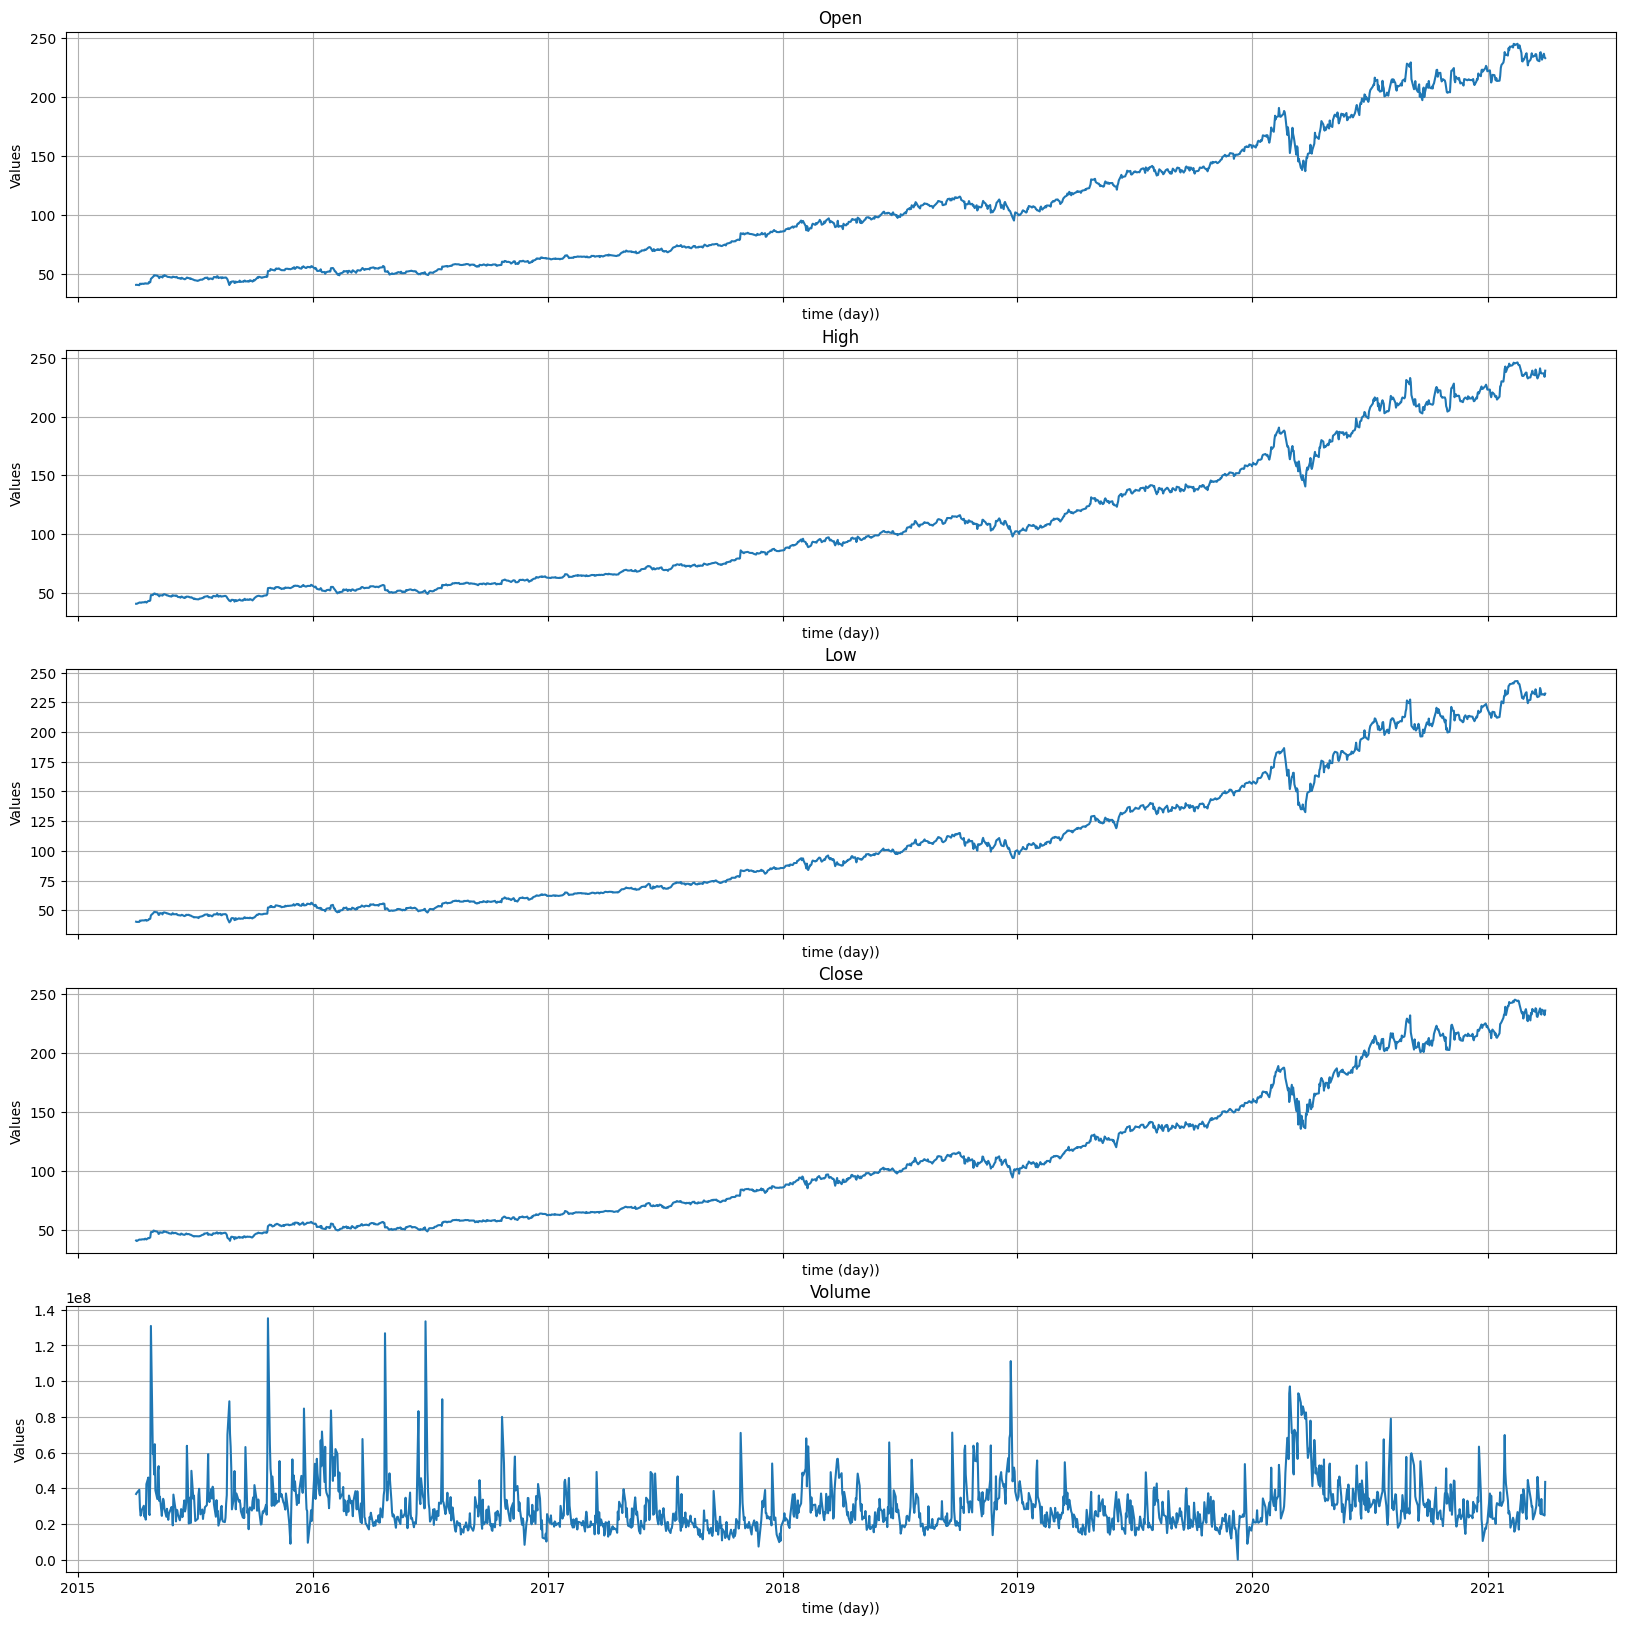

In [ ]:
fig, ax = plt.subplots(nrows = 5, sharex=True, figsize = (20, 20))
for i, col in enumerate(df.columns):
    ax[i].plot(df.index, df[col], label = col)
    ax[i].grid()
    ax[i].set(
        xlabel = "time (day))",
        ylabel = "Values",
        title = col
    )
plt.show()

<Axes: >

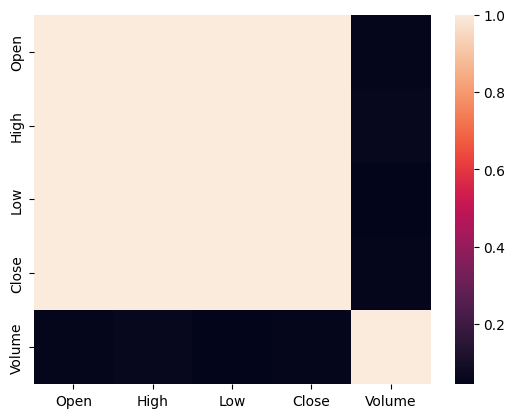

In [12]:
correlation = df.corr()
sns.heatmap(correlation)

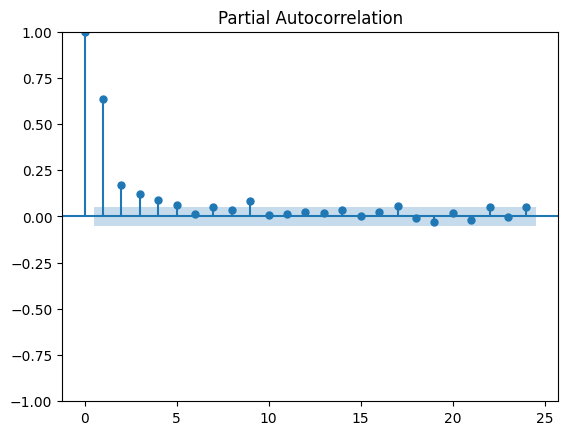

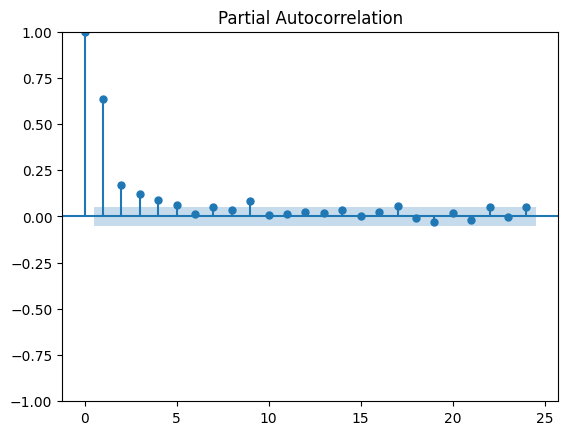

In [13]:
plot_pacf(df["Volume"], lags = 24)

### Periodogram

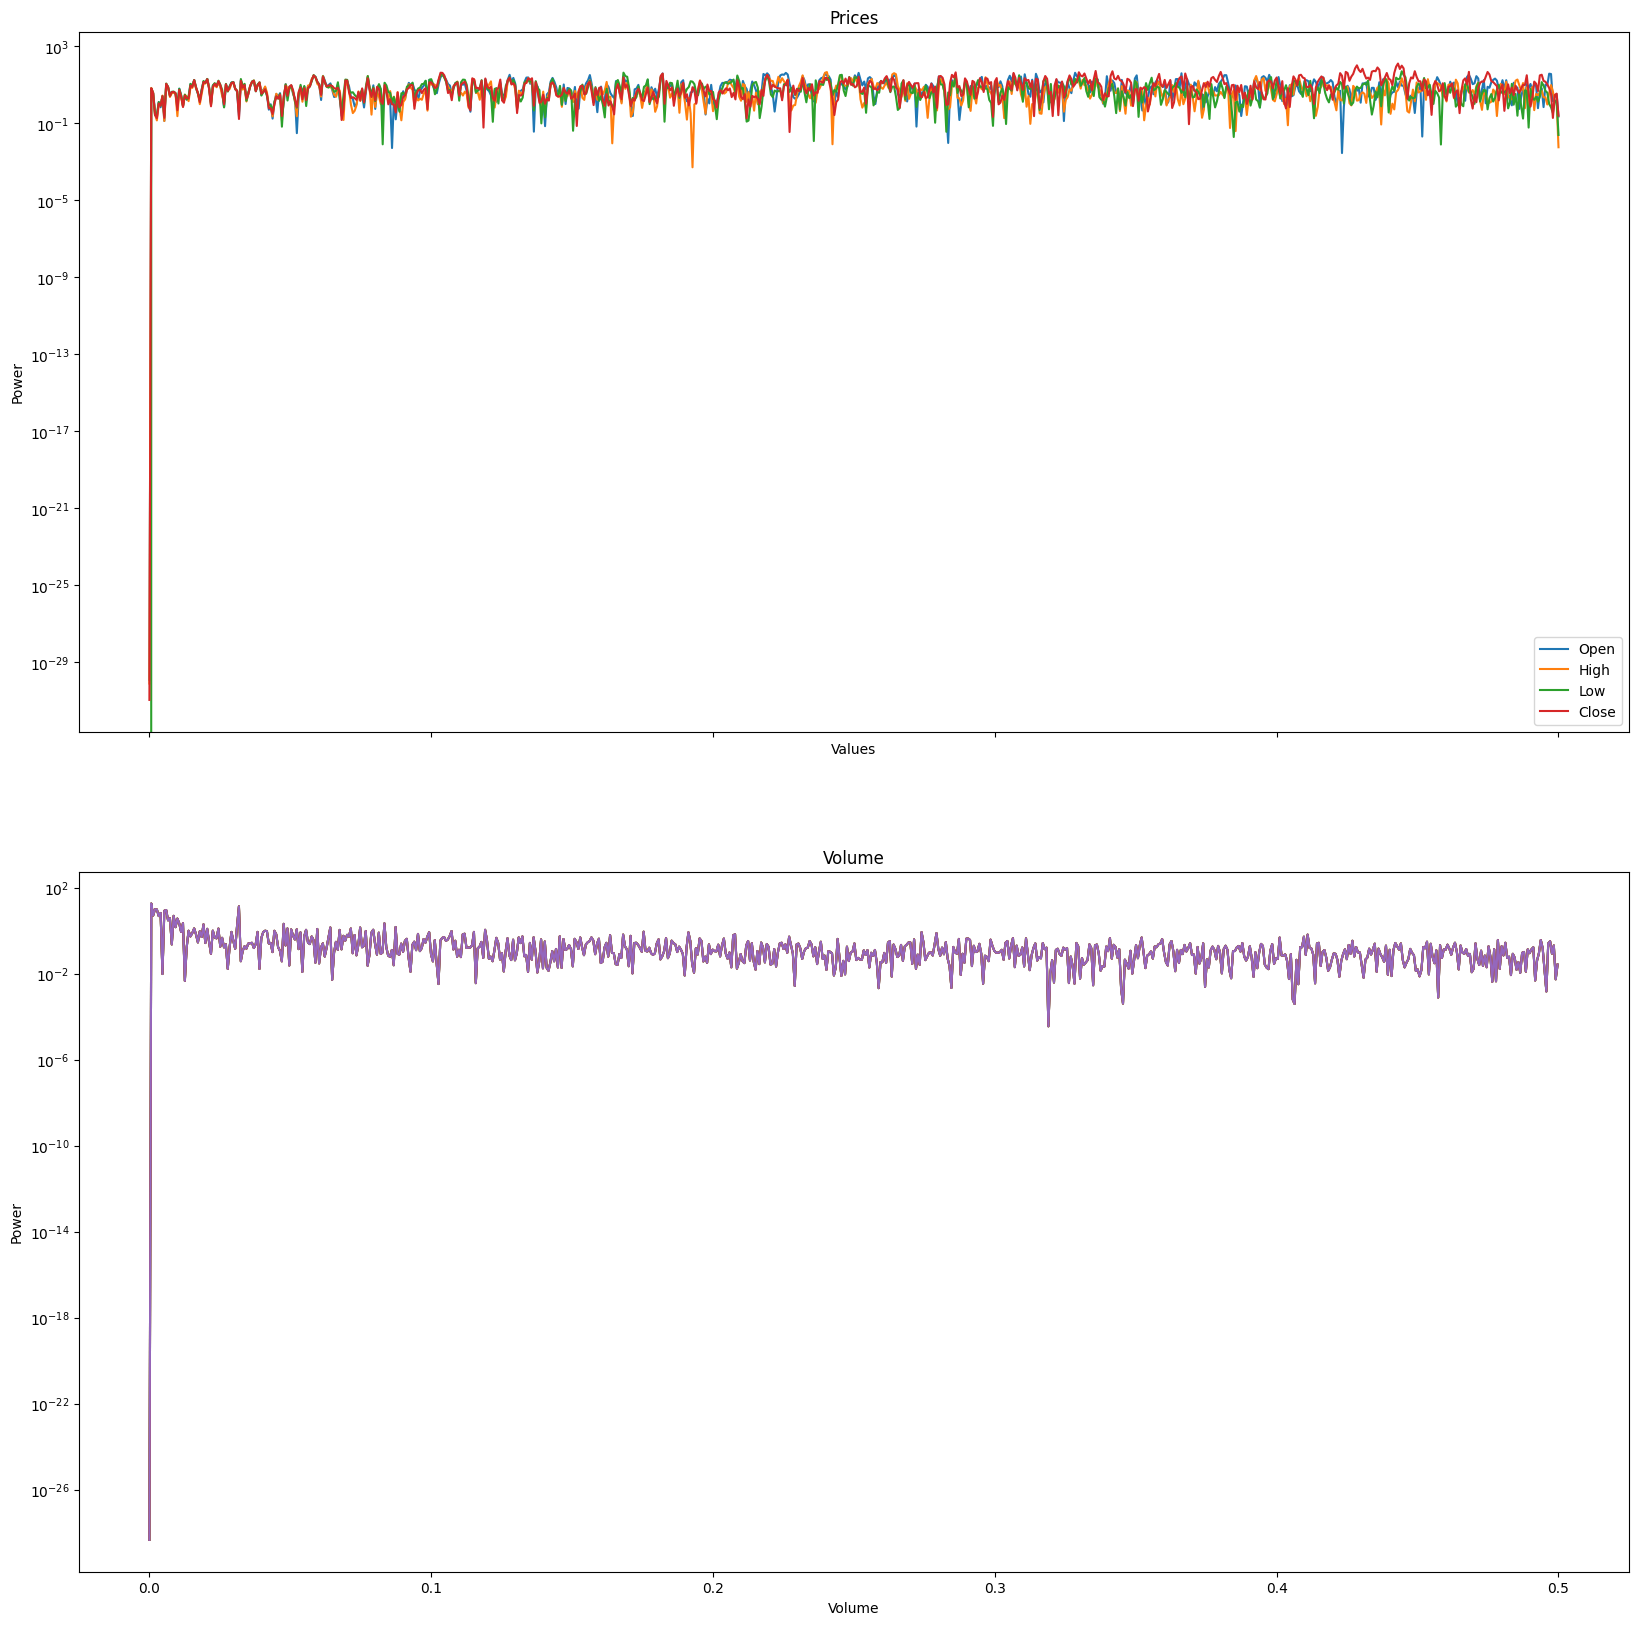

In [14]:
fig, ax = plt.subplots(nrows = 2, sharex=True, figsize = (20, 20))
for i, col in enumerate(df.columns):
    data = np.diff(df[col])
    p, pxx = periodogram(
        # x = (df[col] - df[col].mean()) / df[col].std()
        x = data
    )
    if col != "Volume":
        ax[0].semilogy(p, pxx, label = col)
        ax[0].set(
            xlabel = "Values",
            ylabel = "Power",
            title = "Prices"
        )
        ax[0].legend()
    p, pxx = periodogram(
        x = np.log(df.Volume)
        # x = np.diff(df.Volume)
    )
    ax[1].semilogy(p, pxx)
    ax[1].set(
        xlabel = "Volume",
        ylabel = "Power",
        title = "Volume"
    )
plt.show()



### Stationarity

In [15]:
def check_stationarity(values):
    adf = adfuller(
        x = values.values
    )
    print(f"ADF: %f" % adf[0])
    print(f"P-value: %f" % adf[1])
    if adf[1] <= 0.1 and adf[4]["5%"] > adf[0]:
        print("Stationary!")
    else:
        print("Not Stationary")

In [16]:
for i in df.columns:
    print(f"Checking: {i}")
    check_stationarity(df[i])
    print("---")

Checking: Open
ADF: 0.823915
P-value: 0.992013
Not Stationary
---
Checking: High
ADF: 1.570419
P-value: 0.997766
Not Stationary
---
Checking: Low
ADF: 1.224828
P-value: 0.996153
Not Stationary
---
Checking: Close
ADF: 1.737136
P-value: 0.998216
Not Stationary
---
Checking: Volume
ADF: -6.899656
P-value: 0.000000
Stationary!
---


In [17]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [18]:
def make_lag_dataframe(dataframe, lag: int = 1):
    if isinstance(dataframe, pd.DataFrame):
        for col in dataframe.columns:
            dataframe[f"{col}_lag{lag}"] = dataframe[col].shift(lag)
    
    if isinstance(dataframe, pd.Series):
        lagged = dataframe.shift(lag)
        new_df = pd.DataFrame({dataframe.name : dataframe, f"{dataframe.name}_lag{lag}" : lagged})
        dataframe = new_df
    return dataframe

data_1 = df.drop("Volume", axis = 1)
data_1 = make_lag_dataframe(data_1)

data_2 = df["Volume"]
data_2 = make_lag_dataframe(data_2)
print(data_1)
print(data_2)

                       Open    High     Low   Close  Open_lag1  High_lag1  \
Date                                                                        
2015-04-01 16:00:00   40.60   40.76   40.31   40.72        NaN        NaN   
2015-04-02 16:00:00   40.66   40.74   40.12   40.29      40.60      40.76   
2015-04-06 16:00:00   40.34   41.78   40.18   41.55      40.66      40.74   
2015-04-07 16:00:00   41.61   41.91   41.31   41.53      40.34      41.78   
2015-04-08 16:00:00   41.48   41.69   41.04   41.42      41.61      41.91   
...                     ...     ...     ...     ...        ...        ...   
2021-03-25 16:00:00  235.30  236.94  231.57  232.34     237.85     238.00   
2021-03-26 16:00:00  231.55  236.71  231.55  236.48     235.30     236.94   
2021-03-29 16:00:00  236.59  236.80  231.88  235.24     231.55     236.71   
2021-03-30 16:00:00  233.53  233.85  231.10  231.85     236.59     236.80   
2021-03-31 16:00:00  232.91  239.10  232.39  235.77     233.53     233.85   

### Linear Regression Non-Stationary features

#### Open, High, Low, Close

In [ ]:
x_one = data_1.iloc[1:,4:] # We remove the first row, because lag makes it NaN
print(x_one)
y_one = data_1.iloc[1:,:4]
print(y_one)

                     Open_lag1  High_lag1  Low_lag1  Close_lag1
Date                                                           
2015-04-02 16:00:00      40.60      40.76     40.31       40.72
2015-04-06 16:00:00      40.66      40.74     40.12       40.29
2015-04-07 16:00:00      40.34      41.78     40.18       41.55
2015-04-08 16:00:00      41.61      41.91     41.31       41.53
2015-04-09 16:00:00      41.48      41.69     41.04       41.42
...                        ...        ...       ...         ...
2021-03-25 16:00:00     237.85     238.00    235.32      235.46
2021-03-26 16:00:00     235.30     236.94    231.57      232.34
2021-03-29 16:00:00     231.55     236.71    231.55      236.48
2021-03-30 16:00:00     236.59     236.80    231.88      235.24
2021-03-31 16:00:00     233.53     233.85    231.10      231.85

[1510 rows x 4 columns]
                       Open    High     Low   Close
Date                                               
2015-04-02 16:00:00   40.66   40.74   4

In [31]:
lr_one = LinearRegression()

x_one_train, x_one_test, y_one_train, y_one_test = train_test_split(
    x_one,
    y_one,
    test_size = .3,
    shuffle = False
)

lr_one.fit(
    X = x_one_train,
    y = y_one_train
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
y_one_fit = pd.DataFrame(
    lr_one.predict(x_one_train),
    index = x_one_train.index,
    columns = y_one_train.columns
)

y_one_pred = pd.DataFrame(
    lr_one.predict(x_one_test),
    index = y_one_test.index,
    columns = y_one_test.columns
)

print(y_one_train.dtypes)
print(y_one_fit.dtypes)

res_one = y_one_train - y_one_fit


boost = MultiOutputRegressor(XGBRegressor(max_depth = 3, reg_lambda = 3, reg_alpha = 3))
boost.fit(x_one_train, res_one)
preds_2 = boost.predict(x_one_train)

y_boost_fit = boost.predict(x_one_train) + y_one_fit
y_boost_pred = boost.predict(x_one_test) + y_one_pred


Open     float64
High     float64
Low      float64
Close    float64
dtype: object
Open     float64
High     float64
Low      float64
Close    float64
dtype: object


In [34]:
def get_mse(true, pred):
    mse = root_mean_squared_error(
        y_true = true,
        y_pred = pred
    )
    return mse

In [ ]:
train_mse = get_mse(y_one_train, y_boost_fit)
test_mse = get_mse(y_one_test, y_boost_pred)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 0.743034925064535
Test MSE: 3.0037958631229063


In [35]:
lr_one_fin = LinearRegression()
lr_one_fin.fit(
    X = x_one_train,
    y = y_one_train
)

y_one_fit = pd.DataFrame(
    lr_one_fin.predict(x_one_train),
    index = x_one_train.index,
    columns = y_one_train.columns
)
y_one_pred = pd.DataFrame(
    lr_one_fin.predict(x_one_test),
    index = y_one_test.index,
    columns = y_one_test.columns
)

train_new_mse = get_mse(y_one_train, y_one_fit)
test_new_mse = get_mse(y_one_test, y_one_pred)

print(f"Train MSE: {train_new_mse}")
print(f"Test MSE: {test_new_mse}")

Train MSE: 0.9265520410491199
Test MSE: 2.9844254624559303


#### Volume

In [38]:
x_two = data_2.iloc[1:,1:]
print(x_two)
y_two = data_2.iloc[1:,:1]
print(y_two)

                     Volume_lag1
Date                            
2015-04-02 16:00:00   36865322.0
2015-04-06 16:00:00   37487476.0
2015-04-07 16:00:00   39223692.0
2015-04-08 16:00:00   28809375.0
2015-04-09 16:00:00   24753438.0
...                          ...
2021-03-25 16:00:00   25620127.0
2021-03-26 16:00:00   34061853.0
2021-03-29 16:00:00   25479853.0
2021-03-30 16:00:00   25227455.0
2021-03-31 16:00:00   24792012.0

[1510 rows x 1 columns]
                       Volume
Date                         
2015-04-02 16:00:00  37487476
2015-04-06 16:00:00  39223692
2015-04-07 16:00:00  28809375
2015-04-08 16:00:00  24753438
2015-04-09 16:00:00  25723861
...                       ...
2021-03-25 16:00:00  34061853
2021-03-26 16:00:00  25479853
2021-03-29 16:00:00  25227455
2021-03-30 16:00:00  24792012
2021-03-31 16:00:00  43623471

[1510 rows x 1 columns]


In [42]:
x_two_train, x_two_test, y_two_train, y_two_test = train_test_split(
    x_two,
    y_two,
    test_size = .3,
    shuffle = False
)

lr_two = LinearRegression()
lr_two.fit(
    X = x_two_train,
    y = y_two_train
)

y_two_fit = pd.DataFrame(
    lr_two.predict(x_two_train),
    index = x_two_train.index,
    columns = y_two_train.columns
)
y_two_pred = pd.DataFrame(
    lr_two.predict(x_two_test),
    index = y_two_test.index,
    columns = y_two_test.columns
)

train_two_mse = get_mse(y_two_train, y_two_fit)
test_two_mse = get_mse(y_two_test, y_two_pred)

print(f"Train MSE: {train_two_mse}")
print(f"Test MSE: {test_two_mse}")

Train MSE: 11449410.030873733
Test MSE: 10146633.01554935


## End Graphs

In [47]:
def make_pred_plots(feature_train, feature_fit, feature_name):
    plt.figure(figsize=(12,4))
    plt.plot(feature_train.index, feature_train[feature_name], label = f"Train True {feature_name}")
    plt.plot(feature_train.index, feature_fit[feature_name], label = f"Train Pred {feature_name}")

    plt.title(f"Linear Regression Predictions for {feature_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

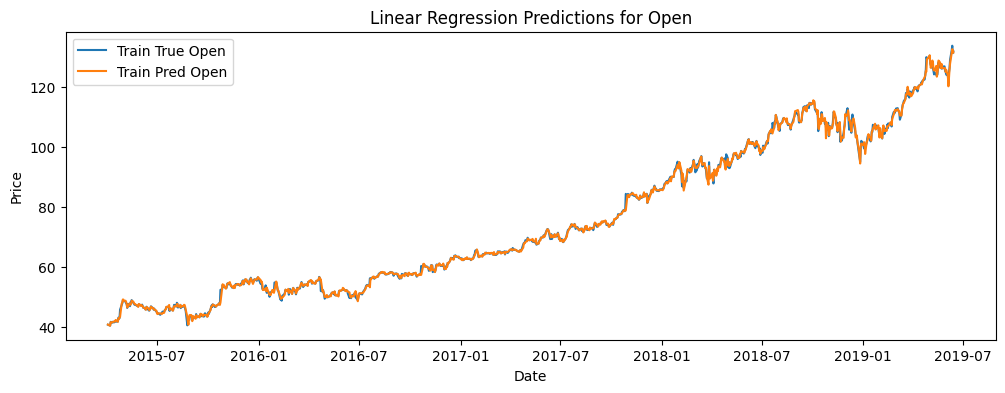

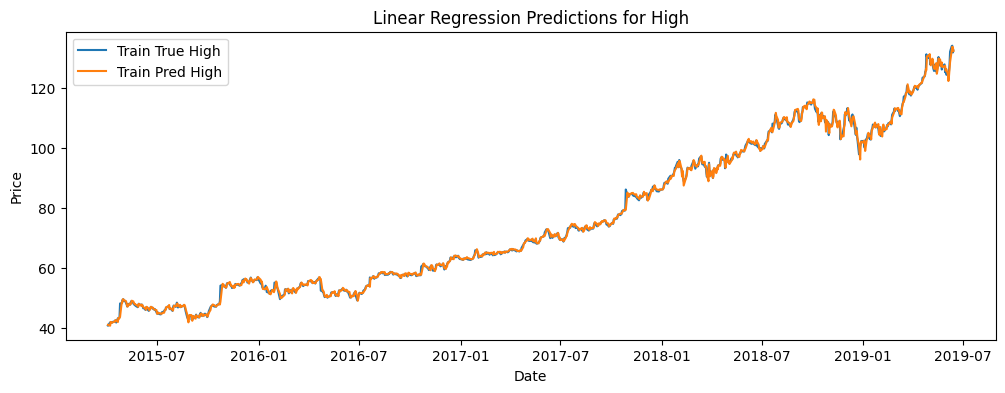

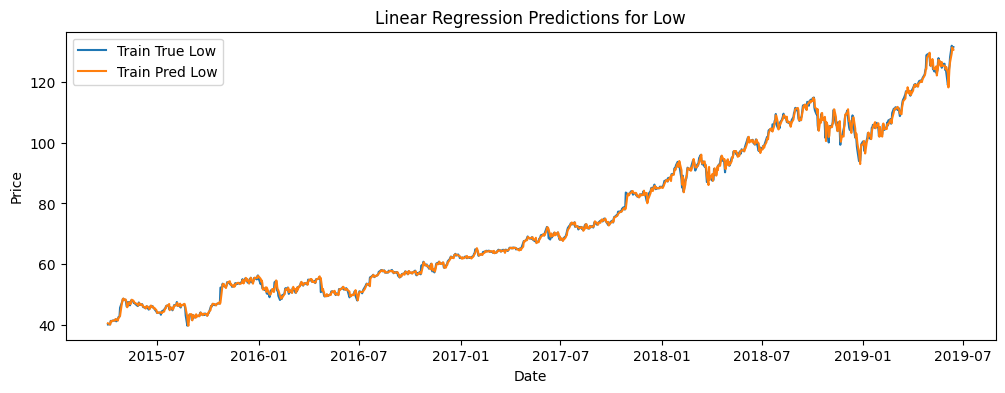

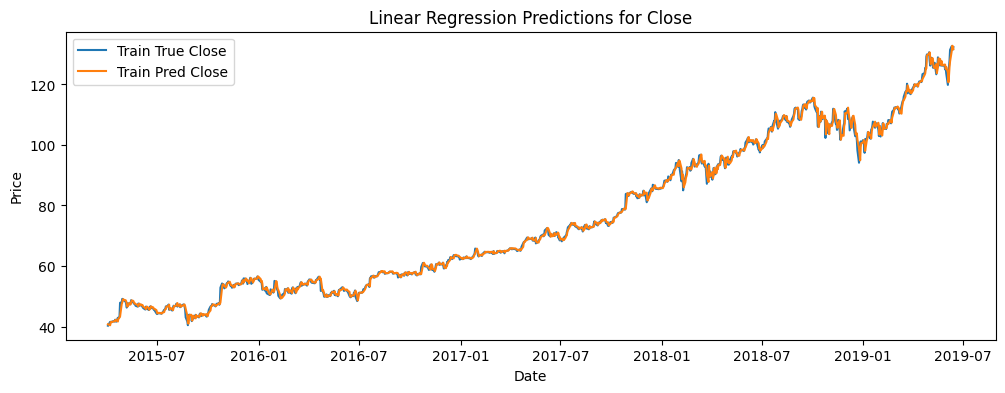

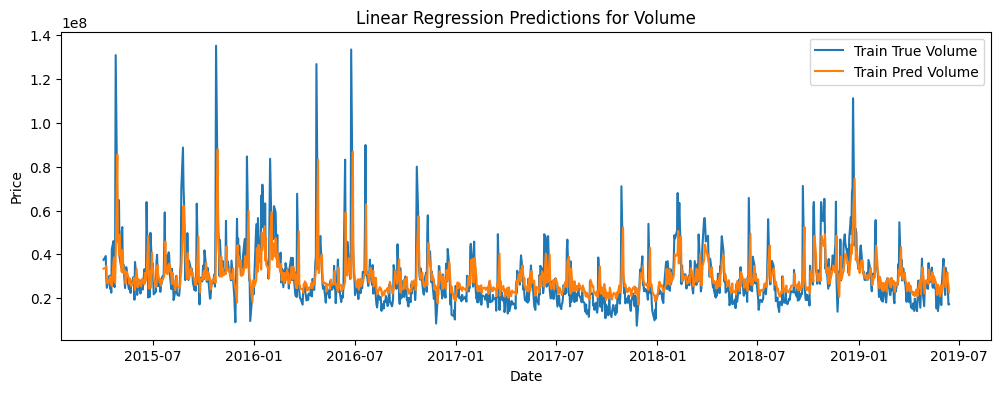

In [49]:
for col in y_one_train.columns:
    make_pred_plots(
        y_one_train,
        y_one_fit,
        col
    )

make_pred_plots(
    y_two_train,
    y_two_fit,
    "Volume"
)